In [1]:
from data_io.loader.data_loader import DataLoader, WeatherData
from data_io.fetch.fetch_weather_data import fetch_weather_data_for_year

In [2]:
dl = DataLoader()

### Data Sanity: Comparison of weather values in bicycle dataset vs. weather dataset

Since we have the weather values (temperature, percipation, ...)  included in the bicycle dataset for each station. It is interesting to compare the values of both datasets.
How reliable is the local weather value of the stations? How often does the sensor fail? 
One would also have to keep in mind that the weather dataset has not the same resolution as the bike count dataset (as seen in `sanity_weather.ipynb`).

We start by comparing the temperatures.

In [3]:
df_merged = dl.get_bicycle_with_weather("Ziegelhäuser Landstraße", interval=("2017-09-01", "2026-10-10"))

In [ ]:
import matplotlib.pyplot as plt

def plot_temp_comparison(interval = ("2017-09-01", "2026-10-10")):
    for station in dl.get_bicyle_stations():
        df_merged = dl.get_bicycle_with_weather(station, interval=interval)

        plt.figure(figsize=(16,6))

        plt.plot(
            df_merged["datetime"],
            df_merged["temperature_2m"],
            label="Weather Temp (temperature_2m)",
            alpha=0.7
        )

        plt.plot(
            df_merged["datetime"],
            df_merged["site_temperature"],
            label="Bike Sensor Temp (site_temperature)",
            alpha=0.7
        )

        plt.title("Bike site_temperature vs Weather temperature_2m")
        plt.xlabel("Datetime")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_temp_comparison()

In [4]:
import polars as pl

def get_temp_diff(station, interval=("2017-09-01", "2026-10-10")):
    df = dl.get_bicycle_with_weather(station, interval=interval)

    # Differenz-Spalte hinzufügen
    df = df.with_columns(
        (pl.col("site_temperature") - pl.col("temperature_2m"))
        .alias("temp_diff")
    )
    return df

<Figure size 1400x600 with 0 Axes>

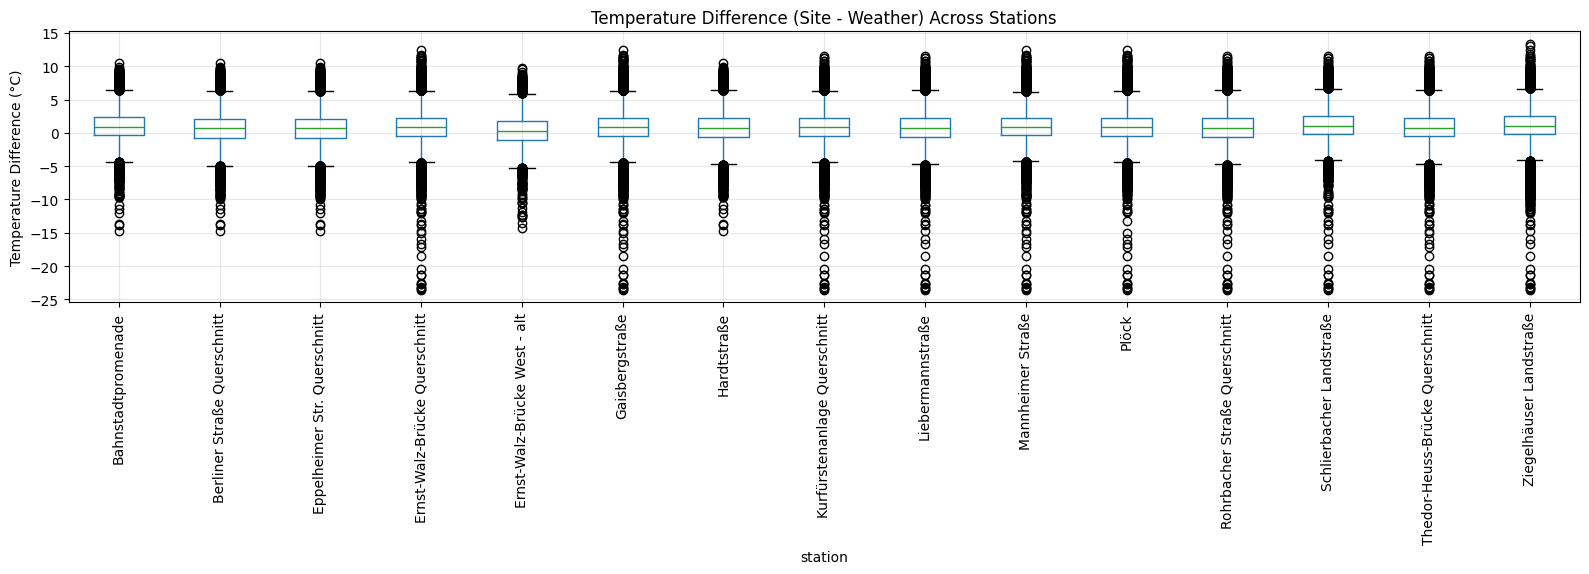

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def boxplot_temp_diff(interval=("2017-09-01", "2026-10-10")):
    rows = []
    for station in dl.get_bicyle_stations():
        df = get_temp_diff(station, interval)
        rows.append(
            pd.DataFrame({
                "station": station,
                "temp_diff": df["temp_diff"].to_list()
            })
        )

    df_all = pd.concat(rows)

    plt.figure(figsize=(14,6))
    df_all.boxplot(by="station", column="temp_diff", rot=90, figsize=(16,6))
    plt.suptitle("")
    plt.title("Temperature Difference (Site - Weather) Across Stations")
    plt.ylabel("Temperature Difference (°C)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
boxplot_temp_diff()

In [8]:
def summary_stats(interval=("2017-09-01", "2026-10-10")):
    stats = []

    for station in dl.get_bicyle_stations():
        df = get_temp_diff(station, interval)

        stats.append({
            "station": station,
            "mean_diff": float(df["temp_diff"].mean()),
            "median_diff": float(df["temp_diff"].median()),
            "std_diff": float(df["temp_diff"].std()),
            "min_diff": float(df["temp_diff"].min()),
            "max_diff": float(df["temp_diff"].max()),
        })

    return pl.DataFrame(stats)

stats_df = summary_stats()
stats_df


station,mean_diff,median_diff,std_diff,min_diff,max_diff
str,f64,f64,f64,f64,f64
"""Ziegelhäuser Landstraße""",1.223495,1.1,2.379814,-23.6,13.4
"""Bahnstadtpromenade""",1.077617,0.9,2.255409,-14.8,10.5
"""Berliner Straße Querschnitt""",0.756926,0.7,2.33144,-14.8,10.5
"""Gaisbergstraße""",0.954838,0.9,2.336907,-23.6,12.4
"""Eppelheimer Str. Querschnitt""",0.728942,0.7,2.334138,-14.8,10.5
…,…,…,…,…,…
"""Thedor-Heuss-Brücke Querschnit…",0.876533,0.8,2.378179,-23.6,11.5
"""Hardtstraße""",0.847625,0.8,2.353229,-14.8,10.5
"""Rohrbacher Straße Querschnitt""",0.850924,0.8,2.363189,-23.6,11.5


We now compare percipation between both datasets

In [9]:
import polars as pl

def get_precip_diff(station, interval=("2017-09-01", "2026-10-10")):
    df = dl.get_bicycle_with_weather(station, interval=interval)

    df = df.with_columns([
        (pl.col("site_rain_accumulation") - pl.col("rain")).alias("rain_diff"),
        (pl.col("site_snow_accumulation") - pl.col("snowfall")).alias("snow_diff")
    ])

    return df

In [ ]:
import matplotlib.pyplot as plt

def plot_precip_comparison(interval=("2017-09-01", "2026-10-10")):
    for station in dl.get_bicyle_stations():

        df = get_precip_diff(station, interval)

        plt.figure(figsize=(16,6))

        plt.plot(df["datetime"], df["rain"], label="Weather rain", alpha=0.7)
        plt.plot(df["datetime"], df["site_rain_accumulation"], label="Bike rain", alpha=0.7)

        plt.title(f"Rain Comparison — {station}")
        plt.xlabel("Datetime")
        plt.ylabel("Rain (mm)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(16,6))

        plt.plot(df["datetime"], df["snowfall"], label="Weather snowfall", alpha=0.7)
        plt.plot(df["datetime"], df["site_snow_accumulation"], label="Bike snowfall", alpha=0.7)

        plt.title(f"Snow Comparison — {station}")
        plt.xlabel("Datetime")
        plt.ylabel("Snow (mm)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
plot_precip_comparison()

<Figure size 1600x600 with 0 Axes>

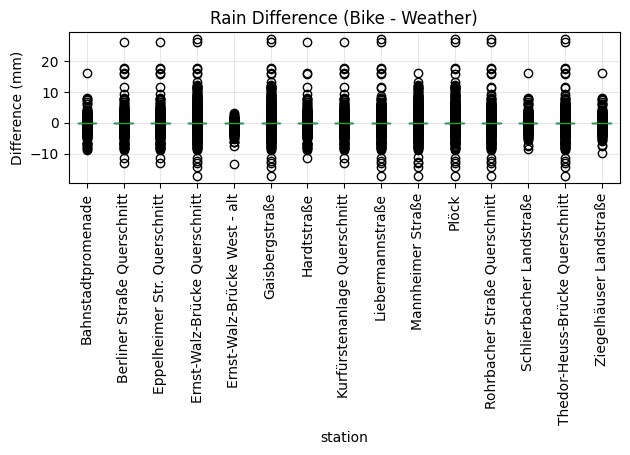

<Figure size 1600x600 with 0 Axes>

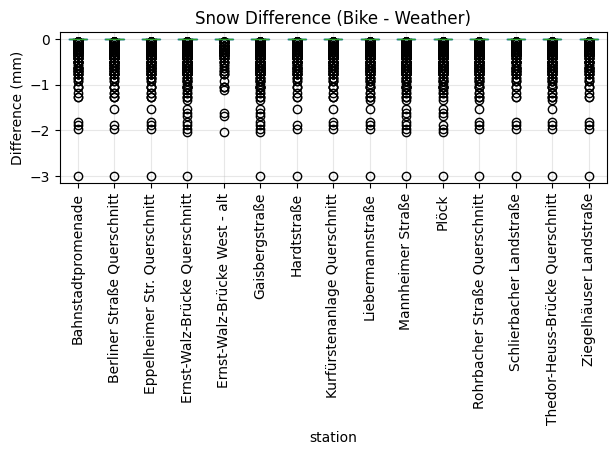

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def boxplot_precip_diff(interval=("2017-09-01", "2026-10-10")):
    rows_rain = []
    rows_snow = []

    for station in dl.get_bicyle_stations():
        df = get_precip_diff(station, interval)

        rows_rain.append(pd.DataFrame({
            "station": station,
            "rain_diff": df["rain_diff"].to_list()
        }))

        rows_snow.append(pd.DataFrame({
            "station": station,
            "snow_diff": df["snow_diff"].to_list()
        }))

    df_rain = pd.concat(rows_rain)
    df_snow = pd.concat(rows_snow)

    # Rain
    plt.figure(figsize=(16,6))
    df_rain.boxplot(by="station", column="rain_diff", rot=90)
    plt.suptitle("")
    plt.title("Rain Difference (Bike - Weather)")
    plt.ylabel("Difference (mm)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Snow
    plt.figure(figsize=(16,6))
    df_snow.boxplot(by="station", column="snow_diff", rot=90)
    plt.suptitle("")
    plt.title("Snow Difference (Bike - Weather)")
    plt.ylabel("Difference (mm)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
boxplot_precip_diff()

### Result
- The temperature seems to have low deviations across all stations. Median of deviation is approximately around 1 - 2 degress for all stations.
- Rain seems to fluctuate much more. Rain sensors of counting stations could be more inconsistent. Rain more local event then temperature. 
- Snow seems not to be captured correctly for all stations.  